###1.a)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mnist = tf.keras.datasets.mnist

In [ ]:
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
index_train = np.where((train_labels == 2) | (train_labels == 6))
index_test = np.where((test_labels == 2) | (test_labels == 6) )
train_images_26 = train_images[index_train]
train_images_26 = train_images_26.reshape((len(train_images_26),train_images_26[1].size))
train_labels_26 = train_labels[index_train].astype('int')
test_images_26 = test_images[index_test]
test_images_26 = test_images_26.reshape((len(test_images_26),test_images_26[1].size))
test_labels_26 = test_labels[index_test].astype('int')
train_labels_26[ np.where(train_labels_26 == 2 )] = -1
train_labels_26[ np.where(train_labels_26 == 6 )] = 1
test_labels_26[ np.where(test_labels_26 == 2 )] = -1
test_labels_26[ np.where(test_labels_26 == 6 )] = 1
(train_images_26)= train_images_26[range(1000)].astype(np.float64)
(train_labels_26)= train_labels_26[range(1000)].astype(np.float64)

train_images_26_norm = train_images_26/255
test_images_26_norm = test_images_26/255


In [ ]:
import cvxpy as cp

In [ ]:
def kernel_svm(sigma):
  a_kernel = cp.Variable((train_labels_26.shape[0]))


  def dot_mat_vector(x):
    mat = np.zeros((len(x), len(x)))
    for i in range(len(x)):
      for j in range(len(x)):
        mat[i][j]= product(x[i],x[j])
    return mat

  def product(c,d):
    
    #sigma = 1
    num = -1*np.sum(np.square(c-d))
    denom = 2*sigma**2
    return np.exp((num/denom))
    

  def dot_mat(x):
    mat = np.zeros((len(x), len(x)))
    for i in range(len(x)):
      for j in range(len(x)):
        mat[i][j]= x[i]*x[j]
    return mat

  mat_x = np.zeros((len(train_images_26_norm), len(train_images_26_norm))).astype(np.float64)
  mat_x = dot_mat_vector(train_images_26_norm)

  mat_y = np.zeros((len(train_labels_26), len(train_labels_26)))
  mat_y = dot_mat(train_labels_26)

  h = np.zeros((train_images_26_norm.shape[0], train_images_26_norm.shape[0])).astype(np.float64)
  h = np.multiply(mat_x,mat_y)


  obj = cp.Maximize(cp.sum(a_kernel)-0.5*cp.quad_form(a_kernel,h))
  c2 = [a_kernel@train_labels_26.T == 0]
  a_const = [a_kernel[i] >=0 for i in range(train_labels_26.shape[0])]

  constraints = c2+a_const
  prob=cp.Problem(obj,constraints)
  prob.solve()
  print("status:", prob.status)
  #print("optimal value", prob.value)


  def summation(x):
    w_sum = 0
    
    for i in range(len(train_labels_26)):
      w_sum += train_labels_26[i]*a_kernel.value[i]*product(train_images_26_norm[i],x)
    return w_sum
  max = -np.inf
  min = np.inf
  for i in range(len(train_images_26_norm)):
    if ( train_labels_26[i] == -1):
      if summation(train_images_26_norm[i]) > max :
        max = summation(train_images_26_norm[i])
    else:
      if summation(train_images_26_norm[i]) < min :
        min = summation(train_images_26_norm[i])

  b_kernel = (-1*(max + min))/2

  incorr = 0
  for j in range(len(train_images_26_norm)): 
        wxtest = summation(train_images_26_norm[j]) + b_kernel
        if wxtest*train_labels_26[j]<=0:
          incorr += 1
  kernel_training_error = ((incorr)/len(train_images_26_norm))
  #print("training error :",kernel_training_error)

  incorr = 0

  for j in range(len(test_images_26_norm)): 
        wxtest = summation(test_images_26_norm[j]) + b_kernel
        if wxtest*test_labels_26[j]<=0:
          incorr += 1
  kernel_testing_error = ((incorr)/len(test_images_26_norm))
  #print("testing error :",kernel_testing_error)
  return kernel_training_error,kernel_testing_error

In [ ]:
sig = [0.2, 0.5, 1, 3, 4, 5, 10]
kernel_training_error=[]
kernel_testing_error=[]
for i in sig:
  a , b = kernel_svm(i)
  kernel_training_error.append(a)
  kernel_testing_error.append(b)
print(kernel_training_error)
print(kernel_testing_error)
from tabulate import tabulate 
table = [["Test","Training Error","Testing Error"],\
         ["K-SVM sig = 0.2 ",kernel_training_error[0],kernel_testing_error[0]],\
         ["K-SVM sig = 0.5 ",kernel_training_error[1],kernel_testing_error[1]],\
         ["K-SVM sig = 1.0 ",kernel_training_error[2],kernel_testing_error[2]],\
         ["K-SVM sig = 3.0 ",kernel_training_error[3],kernel_testing_error[3]],\
         ["K-SVM sig = 4.0 ",kernel_training_error[4],kernel_testing_error[4]],\
         ["K-SVM sig = 5.0 ",kernel_training_error[5],kernel_testing_error[5]],\
         ["K-SVM sig = 10.0 ",kernel_training_error[6],kernel_testing_error[6]]]
#print(tabulate(table))
print(tabulate(table,headers="firstrow",tablefmt="fancy_grid"))

status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
status: optimal
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.5185929648241207, 0.5185929648241207, 0.5185929648241207, 0.021105527638190954, 0.009045226130653266, 0.007537688442211055, 0.013567839195979899]
╒══════════════════╤══════════════════╤═════════════════╕
│ Test             │   Training Error │   Testing Error │
╞══════════════════╪══════════════════╪═════════════════╡
│ K-SVM sig = 0.2  │                0 │      0.518593   │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 0.5  │                0 │      0.518593   │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 1.0  │                0 │      0.518593   │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 3.0  │                0 │      0.0211055  │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 4.0  │                0 │      0.00904523 │
├──────

###1. b)
Tuning the hyperparameter gamma means to adjust the degree of underfitting and overfitting of our model. Lower gamma values tend towards underfitting and higher gamma values tend towards overfitting our model. As we can see that at low values of gamma the degree of underfitting is very large and we get bad testing error. As we increase gamma we can see we start gettin good testing error to a particular limit. As soon as we increase gamma too much , we overfit the model too much and our testing error starts to increase . 

### 1.c)
####SVM

In [ ]:
def svm():
  a_kernel = cp.Variable((train_labels_26.shape[0]))


  def dot_mat_vector(x):
    mat = np.zeros((len(x), len(x)))
    for i in range(len(x)):
      for j in range(len(x)):
        mat[i][j]= product(x[i],x[j])
    return mat

  def product(c,d):
    return np.dot(c,d)
    
  def dot_mat(x):
    mat = np.zeros((len(x), len(x)))
    for i in range(len(x)):
      for j in range(len(x)):
        mat[i][j]= x[i]*x[j]
    return mat

  mat_x = np.zeros((len(train_images_26_norm), len(train_images_26_norm))).astype(np.float64)
  mat_x = dot_mat_vector(train_images_26_norm)

  mat_y = np.zeros((len(train_labels_26), len(train_labels_26)))
  mat_y = dot_mat(train_labels_26)

  h = np.zeros((train_images_26_norm.shape[0], train_images_26_norm.shape[0])).astype(np.float64)
  h = np.multiply(mat_x,mat_y)


  obj = cp.Maximize(cp.sum(a_kernel)-0.5*cp.quad_form(a_kernel,h))
  c2 = [a_kernel@train_labels_26.T == 0]
  a_const = [a_kernel[i] >=0 for i in range(train_labels_26.shape[0])]

  constraints = c2+a_const
  prob=cp.Problem(obj,constraints)
  prob.solve()
  print("status:", prob.status)
  #print("optimal value", prob.value)


  def summation(x):
    w_sum = 0
    
    for i in range(len(train_labels_26)):
      w_sum += train_labels_26[i]*a_kernel.value[i]*product(train_images_26_norm[i],x)
    return w_sum
  max = -np.inf
  min = np.inf
  for i in range(len(train_images_26_norm)):
    if ( train_labels_26[i] == -1):
      if summation(train_images_26_norm[i]) > max :
        max = summation(train_images_26_norm[i])
    else:
      if summation(train_images_26_norm[i]) < min :
        min = summation(train_images_26_norm[i])

  b_kernel = (-1*(max + min))/2

  incorr = 0
  for j in range(len(train_images_26_norm)): 
        wxtest = summation(train_images_26_norm[j]) + b_kernel
        if wxtest*train_labels_26[j]<=0:
          incorr += 1
  kernel_training_error = ((incorr)/len(train_images_26_norm))
  #print("training error :",kernel_training_error)

  incorr = 0

  for j in range(len(test_images_26_norm)): 
        wxtest = summation(test_images_26_norm[j]) + b_kernel
        if wxtest*test_labels_26[j]<=0:
          incorr += 1
  kernel_testing_error = ((incorr)/len(test_images_26_norm))
  #print("testing error :",kernel_testing_error)
  return kernel_training_error,kernel_testing_error

In [ ]:
svm_train,svm_test = svm()
print(f'Training error for SVM is {svm_train} and testing error for SVM is {svm_test}')

status: optimal
Training error for SVM is 0.0 and testing error for SVM is 0.024623115577889446


####Perceptron Algorithm

In [ ]:
train_images_26_w_dummy = np.insert(train_images_26_norm,784,1,axis = 1)
test_images_26_w_dummy = np.insert(test_images_26_norm,784,1,axis = 1)

In [ ]:

w_vector = np.ones(train_images_26_w_dummy.shape[1]) # omega is initialised as a vector filled with ones
i = 0
stopping_criteria = 1    # setting our stopping criteria for breaking out of  the training loop
while i < len(train_images_26_w_dummy):  # we loop over the 1000 training elements continuosly until we are able to classify 95% of it correctly
  wx = np.matmul(np.transpose(w_vector),train_images_26_w_dummy[i]) # predicted label is found out for given sample in training dataset
  if wx*train_labels_26[i]<=0: # checking wthether there is a match between predicted label and given label. If the prediction is wrong we update omega
    w_vector = w_vector + (0.1*train_labels_26[i]*train_images_26_w_dummy[i]) # omega vector is updated
    incorr = 0                  # variable to count no of incorrect predictions.
    for j in range(len(train_images_26_w_dummy)): # everytime we update omega we calculate the training error for the entire training dataset
      wxtest = np.matmul(np.transpose(w_vector),train_images_26_w_dummy[j])
      if wxtest*train_labels_26[j]<=0:
        incorr += 1            
    if ((1000-incorr)/1000)>=stopping_criteria: # if we have classified 95 % of  training dataset correctly we stop the loop and break out.
      print("training error :",((incorr)/1000)) # print final training error before stopping training loop.
      percep_train = (incorr)/1000
      break
  i += 1
  if i == 1000:       #if we reach the end of the 1000 training data set we go back to the beginning of the set to continue training until criterion is reached
    i = 0

incorr = 0
for i in range(len(test_images_26_w_dummy)):
  wx = np.matmul(np.transpose(w_vector),test_images_26_w_dummy[i]) # with the improved omega we classify the test data and calculate testing error
  if wx*test_labels_26[i]<=0: #if we predicted wrongly we increment the variable for incorrect predictions.
    incorr += 1 
print("testing error",((incorr)/len(test_images_26_w_dummy)))
percep_test = (incorr)/len(test_images_26_w_dummy)

training error : 0.0
testing error 0.03869346733668342


#### KNN K=3

In [ ]:
#KNN for k = 3
k = 3
incorr = 0  #incorrect label is initialized as zero
for i in range(0,len(train_images_26_w_dummy)):
        dist = [] #initialize distance vector as empty array
        dist = np.sqrt(np.sum((train_images_26_w_dummy[i]-train_images_26_w_dummy)**2,axis = 1)) #calculate distance of training sample from all of the rest of the training data
        rank = np.argsort(dist) #sort the distances and return the indices of the sorted array using numpy argsort function
        vote = 0 #initialize majority vote as neutral 0 ,neither +1 nor -1
        for j in range(k):
            vote += train_labels_26[rank[j]] #sum of the training lablels of k least distances will give the predicted label for the sample.( -1 and 1 will cancel each other)
        if vote*train_labels_26[i] < 0: #if sign of the predicted and actual label is different ,there product is less than zero and it will be incorrect prediction
          incorr +=1  #increment counter for incorrect prediction 
        
print("training error :",((incorr)/len(train_images_26)),"Incorrect classified : ",incorr) #print training error
k3_train = ((incorr)/len(train_images_26))

incorr = 0  #incorrect label is initialized as zero
for i in range(0,len(test_images_26_w_dummy)):
        dist = [] #initialize distance vector as empty array
        dist = np.sqrt(np.sum((test_images_26_w_dummy[i]-train_images_26_w_dummy)**2,axis = 1)) #calculate distance of testing sample from all of the rest of the training data
        rank = np.argsort(dist) #sort the distances and return the indices of the sorted array using numpy argsort function
        vote = 0 #initialize majority vote as neutral 0 ,neither +1 nor -1
        for j in range(k):
            vote += train_labels_26[rank[j]]#sum of the training lablels of k least distances will give the predicted label for the sample. ( -1 and 1 will cancel each other)
        if vote*test_labels_26[i] < 0: #if sign of the predicted and actual label is different ,there product is less than zero and it will be incorrect prediction
          incorr +=1  #increment counter for incorrect prediction 
        

print("testing error :",((incorr)/len(test_images_26)),"Incorrect classified : ",incorr) #print testing error
k3_test = ((incorr)/len(test_images_26))

training error : 0.002 Incorrect classified :  2
testing error : 0.006030150753768844 Incorrect classified :  12


#### KNN K=5

In [ ]:
#KNN for k = 5

k = 5
incorr = 0
for i in range(0,len(train_images_26_w_dummy)):
        dist = []
        dist = np.sqrt(np.sum((train_images_26_w_dummy[i]-train_images_26_w_dummy)**2,axis = 1))
        rank = np.argsort(dist)
        vote = 0
        for j in range(k):
            vote += train_labels_26[rank[j]]
        if vote*train_labels_26[i] < 0:
          incorr +=1  
        

print("training error :",((incorr)/len(train_images_26_w_dummy)),"Incorrect classified : ",incorr)
k5_train = ((incorr)/len(train_images_26))

incorr = 0
for i in range(0,len(test_images_26_w_dummy)):
        dist = []
        dist = np.sqrt(np.sum((test_images_26_w_dummy[i]-train_images_26_w_dummy)**2,axis = 1))
        rank = np.argsort(dist)
        vote = 0
        for j in range(k):
            vote += train_labels_26[rank[j]]
        if vote*test_labels_26[i] < 0:
          incorr +=1  
        

print("testing error :",((incorr)/len(test_images_26_w_dummy)),"Incorrect classified : ",incorr)
k5_test = ((incorr)/len(test_images_26_w_dummy))
#As K value increases , the difference between training error and test error reduces . And hence there is a more 
#consistent prediction in both training dataset and test dataset.

training error : 0.006 Incorrect classified :  6
testing error : 0.007035175879396985 Incorrect classified :  14


In [ ]:
from tabulate import tabulate 
table = [["Test","Training Error","Testing Error"],\
         ["K-SVM sig = 0.2 ",kernel_training_error[0],kernel_testing_error[0]],\
         ["K-SVM sig = 0.5 ",kernel_training_error[1],kernel_testing_error[1]],\
         ["K-SVM sig = 1.0 ",kernel_training_error[2],kernel_testing_error[2]],\
         ["K-SVM sig = 3.0 ",kernel_training_error[3],kernel_testing_error[3]],\
         ["K-SVM sig = 4.0 ",kernel_training_error[4],kernel_testing_error[4]],\
         ["K-SVM sig = 5.0 ",kernel_training_error[5],kernel_testing_error[5]],\
         ["K-SVM sig = 10.0 ",kernel_training_error[6],kernel_testing_error[6]],\
         ["SVM ",svm_train,svm_test],\
         ["Perceptron ",percep_train,percep_test],\
         ["KNN K=3 ",k3_train,k3_test],\
         ["KNN K=5 ",k5_train,k5_test]]
#print(tabulate(table))
print(tabulate(table,headers="firstrow",tablefmt="fancy_grid"))

╒══════════════════╤══════════════════╤═════════════════╕
│ Test             │   Training Error │   Testing Error │
╞══════════════════╪══════════════════╪═════════════════╡
│ K-SVM sig = 0.2  │            0     │      0.518593   │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 0.5  │            0     │      0.518593   │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 1.0  │            0     │      0.518593   │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 3.0  │            0     │      0.0211055  │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 4.0  │            0     │      0.00904523 │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 5.0  │            0     │      0.00753769 │
├──────────────────┼──────────────────┼─────────────────┤
│ K-SVM sig = 10.0 │            0     │      0.0135678  │
├──────────────────┼──────────────────┼─────────────────┤
│ SVM         

###1.d)
Here we have done simple cross validation with different models because data is not scarce. We can see from the results that KNN for K=3 produces the lowest testing error , even though its not perfectly 0 training error. At the same time K-SVM with sigma = 5.0 also provides same comparable very good testing error with 0 training error. 

###Q2. Linear Regression (Batch gradient descent)

In [ ]:
import numpy as np

x1 =  np.asarray([3,1])
x2 = np.asarray([2,1])
y1 = 3
y2 = 4
x=[x1,x2]
y=[y1,y2]

theta = np.zeros(len(y))
alpha = 0.1
count = 1
i=0

while(count<6):
  sum = np.zeros(len(y))
  for j in range(len(y)):
    
    sum += (np.matmul(np.transpose(theta),x[j])-y[j])*x[j]
  theta -= alpha*(1/len(x))*sum
  print(theta)
  
  count += 1 
  sum = 0
  for j in range(len(y)):
    sum += (np.matmul(np.transpose(theta),x[j])-y[j])**2
  l2loss = (1/len(y))*sum
  
  #print("l2 loss",l2loss)
  

[0.85 0.35]
[1.06   0.4525]
[1.107875 0.49225 ]
[1.11469375 0.51605625]
[1.11112875 0.53577719]


In [ ]:
theta

array([-1.,  6.])

###2.b)

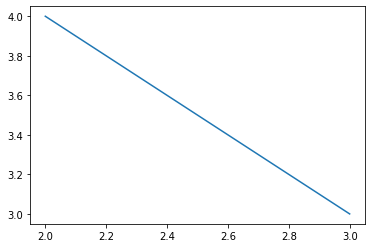

In [ ]:
p_linear = np.polyfit([3,2],[3,4],1)
y3_linear = p_linear[0]*3+p_linear[1]
y2_linear = p_linear[0]*2+p_linear[1]
plt.plot([3,2],[y3_linear,y2_linear])
plt.show()

###2. c)

In [ ]:
noise = np.random.normal(0,1,10)
x= (np.arange(10)-5)/2
y = np.power(x,3)-np.power(x,2)+1+noise

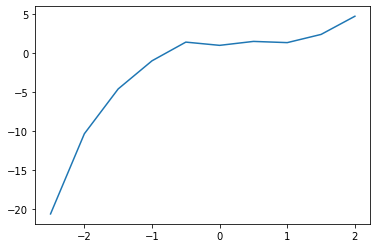

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,y)

In [ ]:
p1 = np.polyfit(x,y,1)
p2 = np.polyfit(x,y,2)
p3 = np.polyfit(x,y,3)
p4 = np.polyfit(x,y,4)
p5 = np.polyfit(x,y,5)

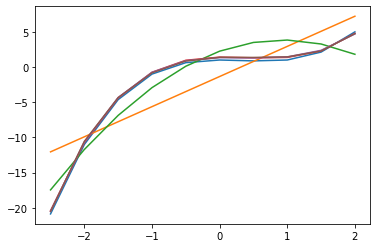

In [ ]:
y_truth = x**3 - x**2 + 1 
y1 = p1[0]*x+p1[1]
y2 = p2[0]*np.power(x,2)+p2[1]*x+p2[2]
y3 = p3[0]*np.power(x,3)+p3[1]*np.power(x,2)+p3[2]*x+p3[3]
y4 = p4[0]*np.power(x,4)+p4[1]*np.power(x,3)+p4[2]*np.power(x,2)+p4[3]*x+p4[4]
y5 = p5[0]*np.power(x,5)+p5[1]*np.power(x,4)+p5[2]*np.power(x,3)+p5[3]*np.power(x,2)+p5[4]*x+p5[5]
plt.plot(x,y_truth,x,y1,x,y2,x,y3,x,y4,x,y5)

Underfitting model is any model that fails to model the training data sufficienty well. It will fail to predict training data satisfactorily. Hence it will fail to predict new data also . 
Overfitting will predict training data too well and learn to adapt to noise also. Hence it will perform poorly on new data . 
Higher the degree of the polynomial regression , higher the fitting and more overfitting. Degree 1 and 2 are underfitting. 
Degree 3 is perfect model with perfect balance .
Degree 4 and 5 are overfitting and will be sensitive to noise elements in test data.

In practise if we see that training error is poor , then model is underfitting and we have to increase the degree to avoid underfitting.
If we see that training error is very low , but testing error is high , then we have to decrease the degree to avoid overfitting. Hence we will perform well on unseen data.